# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter. 

In [1]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/drive/MyDrive/assignment3_starter/assignment3_part1"
if not os.path.exists(datadir):
  !ln -s "/content/drive/MyDrive/assignment3_starter/assignment3_part1" $datadir # TODO: Fill your A3 path
os.chdir(datadir)
!pwd
#"/content/drive/My Drive/path/to/your/assignment3_starter/assignment3_part1"
#/content/drive/MyDrive/assignment3_starter/assignment3_part1

/content/drive/MyDrive/assignment3_starter/assignment3_part1


#Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    elif rot == 1: # 90 degrees rotation
        return torch.rot90(img.permute(1,2,0), 3).permute(2,0,1)
    elif rot == 2: # 180 degrees rotation
        return torch.rot90(img, 2)
    elif rot == 3: # 270 degrees rotation
        return torch.rot90(img.permute(1,2,0), 1).permute(2,0,1)
    
    # TODO: Implement rotate_img() - return the rotated img
    #
    #
    #
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Show some example images and rotated images with labels:

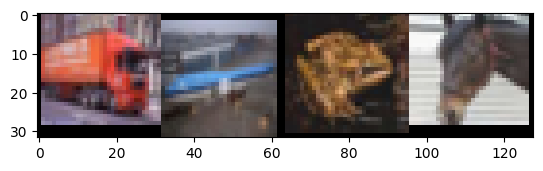

Class labels:  truck plane frog  horse


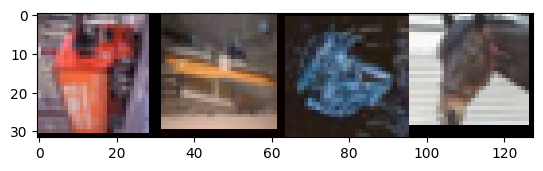

Rotation labels:  270   180   180   0    


In [ ]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

#Evaluation code

In [ ]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            #
            #
            #
            # Calculate outputs by running images through the network


            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)

            #correct += labels.size(0)
            total += labels.size(0)
            # loss
            correct += (predicted == labels).sum().item()
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
            
            # doubt on below line
            #total += avg_test_loss


    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {(100 * correct) / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [ ]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#Train a ResNet18 on the rotation task

In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [ ]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'


device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)



In [ ]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()
        adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

        
        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            #

            # TODO: Zero the parameter gradients
            #

            # TODO: forward + backward + optimize
            #
            #
            #
            #
            #
            # Set the data to the correct device; Different task will use different inputs and labels
            if task == 'rotation':
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
              images, labels = imgs.to(device), cls_label.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # TODO: Get predicted results

            predicted = torch.argmax(outputs, 1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        #
        #
        net.eval()
        run_test(net, testloader, criterion, task)

    print('Finished Training')

In [ ]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.1, task='rotation')

# TODO: Save the model
#
torch.save(net.state_dict(), 'rotation_model.pth')

[1,   100] loss: 0.630 acc: 71.41 time: 7.69
[1,   200] loss: 0.627 acc: 72.17 time: 5.96
[1,   300] loss: 0.619 acc: 72.41 time: 7.33
TESTING:
Accuracy of the network on the 10000 test images: 64.59 %
Average loss on the 10000 test images: 0.937
[2,   100] loss: 0.602 acc: 73.03 time: 7.58
[2,   200] loss: 0.611 acc: 72.48 time: 5.75
[2,   300] loss: 0.608 acc: 72.95 time: 7.37
TESTING:
Accuracy of the network on the 10000 test images: 63.24 %
Average loss on the 10000 test images: 0.902
[3,   100] loss: 0.587 acc: 74.07 time: 7.20
[3,   200] loss: 0.586 acc: 74.17 time: 5.70
[3,   300] loss: 0.588 acc: 73.80 time: 7.36
TESTING:
Accuracy of the network on the 10000 test images: 67.88 %
Average loss on the 10000 test images: 0.808
[4,   100] loss: 0.587 acc: 74.11 time: 6.75
[4,   200] loss: 0.591 acc: 73.95 time: 6.10
[4,   300] loss: 0.584 acc: 74.16 time: 7.07
TESTING:
Accuracy of the network on the 10000 test images: 62.32 %
Average loss on the 10000 test images: 0.953
[5,   100] l

##Fine-tuning on the pre-trained model

In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models

# Load the previously trained ResNet18 model
net = models.resnet18(num_classes=4)

saved_path = 'rotation_model.pth'
net.load_state_dict(torch.load(saved_path))

# Move the model to the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#net.to(device)


num_classes = 10  
net.fc = nn.Linear(net.fc.in_features, num_classes).to(device)


In [ ]:
# num_classes = 10
# net.fc = nn.Linear(net.fc.in_features, num_classes)


In [ ]:


for param in net.parameters():
    param.requires_grad = False


# Unfreeze the 'layer4' block and 'fc' layer
for param in net.layer4.parameters():
    param.requires_grad = True

for param in net.fc.parameters():
    param.requires_grad = True

In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update, lr=0.01)
#num_epochs = 10
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)


In [ ]:
train(net, criterion, optimizer, num_epochs=30, decay_epochs=10, init_lr=0.1, task='classification')


[1,   100] loss: 1.948 acc: 30.16 time: 12.81
[1,   200] loss: 1.644 acc: 39.15 time: 7.16
[1,   300] loss: 1.597 acc: 41.70 time: 5.55
TESTING:
Accuracy of the network on the 10000 test images: 43.95 %
Average loss on the 10000 test images: 1.541
[2,   100] loss: 1.517 acc: 44.62 time: 5.62
[2,   200] loss: 1.510 acc: 44.86 time: 7.31
[2,   300] loss: 1.527 acc: 44.70 time: 5.43
TESTING:
Accuracy of the network on the 10000 test images: 47.27 %
Average loss on the 10000 test images: 1.478
[3,   100] loss: 1.474 acc: 46.41 time: 5.64
[3,   200] loss: 1.482 acc: 46.03 time: 7.02
[3,   300] loss: 1.454 acc: 47.38 time: 5.76
TESTING:
Accuracy of the network on the 10000 test images: 48.26 %
Average loss on the 10000 test images: 1.435
[4,   100] loss: 1.458 acc: 48.16 time: 5.72
[4,   200] loss: 1.447 acc: 47.85 time: 7.14
[4,   300] loss: 1.454 acc: 47.47 time: 5.57
TESTING:
Accuracy of the network on the 10000 test images: 48.56 %
Average loss on the 10000 test images: 1.436
[5,   100] 

## Fine-tuning on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

# Randomly initialize a ResNet18 model
net = resnet18(num_classes=10)

net = net.to(device)

In [ ]:
for param in net.parameters():
    param.requires_grad = False
    
# Unfreeze the 'layer4' block and 'fc' layer
for param in net.layer4.parameters():
    param.requires_grad = True

for param in net.fc.parameters():
    param.requires_grad = True

In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
# criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(params_to_update, lr=0.001, weight_decay=1e-2)


In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=4, init_lr=0.1, task='classification')

[1,   100] loss: 3.534 acc: 21.99 time: 5.90
[1,   200] loss: 2.007 acc: 29.26 time: 7.46
[1,   300] loss: 1.884 acc: 31.75 time: 5.69
TESTING:
Accuracy of the network on the 10000 test images: 37.71 %
Average loss on the 10000 test images: 1.738
[2,   100] loss: 1.815 acc: 33.91 time: 5.96
[2,   200] loss: 1.791 acc: 34.80 time: 8.65
[2,   300] loss: 1.776 acc: 36.28 time: 5.91
TESTING:
Accuracy of the network on the 10000 test images: 38.72 %
Average loss on the 10000 test images: 1.694
[3,   100] loss: 1.748 acc: 36.70 time: 7.13
[3,   200] loss: 1.742 acc: 36.58 time: 6.13
[3,   300] loss: 1.740 acc: 37.04 time: 6.12
TESTING:
Accuracy of the network on the 10000 test images: 39.48 %
Average loss on the 10000 test images: 1.661
[4,   100] loss: 1.715 acc: 37.73 time: 7.58
[4,   200] loss: 1.719 acc: 38.31 time: 5.82
[4,   300] loss: 1.707 acc: 38.20 time: 6.90
TESTING:
Accuracy of the network on the 10000 test images: 39.20 %
Average loss on the 10000 test images: 1.672
[5,   100] l

##Supervised training on the pre-trained model
In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = models.resnet18(num_classes=4)

saved_path = 'rotation_model.pth'
net.load_state_dict(torch.load(saved_path))

# Move the model to the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

num_classes = 10  
net.fc = nn.Linear(net.fc.in_features, num_classes).to(device)

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay=1e-2)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(net.parameters(), lr=0.1)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=4, init_lr=0.1, task='classification')

[1,   100] loss: 0.775 acc: 73.11 time: 6.02
[1,   200] loss: 0.773 acc: 72.98 time: 7.19
[1,   300] loss: 0.767 acc: 73.49 time: 5.92
TESTING:
Accuracy of the network on the 10000 test images: 73.87 %
Average loss on the 10000 test images: 0.754
[2,   100] loss: 0.777 acc: 72.91 time: 5.85
[2,   200] loss: 0.769 acc: 73.43 time: 7.41
[2,   300] loss: 0.764 acc: 73.38 time: 5.81
TESTING:
Accuracy of the network on the 10000 test images: 72.19 %
Average loss on the 10000 test images: 0.801
[3,   100] loss: 0.782 acc: 73.09 time: 6.03
[3,   200] loss: 0.785 acc: 72.61 time: 7.26
[3,   300] loss: 0.789 acc: 72.83 time: 5.77
TESTING:
Accuracy of the network on the 10000 test images: 71.88 %
Average loss on the 10000 test images: 0.817
[4,   100] loss: 0.806 acc: 72.06 time: 6.35
[4,   200] loss: 0.806 acc: 72.11 time: 8.15
[4,   300] loss: 0.822 acc: 71.71 time: 5.88
TESTING:
Accuracy of the network on the 10000 test images: 67.50 %
Average loss on the 10000 test images: 0.920
[5,   100] l

##Supervised training on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

# Randomly initialize a ResNet18 model
net = resnet18(num_classes=10)

net = net.to(device)

In [ ]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.046 acc: 26.81 time: 13.62
[1,   200] loss: 1.719 acc: 37.32 time: 8.32
[1,   300] loss: 1.574 acc: 42.45 time: 6.32
TESTING:
Accuracy of the network on the 10000 test images: 50.10 %
Average loss on the 10000 test images: 1.395
[2,   100] loss: 1.444 acc: 47.64 time: 6.02
[2,   200] loss: 1.374 acc: 50.68 time: 7.47
[2,   300] loss: 1.304 acc: 53.44 time: 5.87
TESTING:
Accuracy of the network on the 10000 test images: 55.24 %
Average loss on the 10000 test images: 1.267
[3,   100] loss: 1.229 acc: 55.73 time: 8.78
[3,   200] loss: 1.189 acc: 57.82 time: 10.25
[3,   300] loss: 1.165 acc: 57.84 time: 9.39
TESTING:
Accuracy of the network on the 10000 test images: 58.02 %
Average loss on the 10000 test images: 1.218
[4,   100] loss: 1.101 acc: 61.19 time: 7.15
[4,   200] loss: 1.101 acc: 60.45 time: 6.65
[4,   300] loss: 1.059 acc: 62.81 time: 7.44
TESTING:
Accuracy of the network on the 10000 test images: 63.80 %
Average loss on the 10000 test images: 1.060
[5,   100]

Extra part a)

**Part 1 Extra Credit (b)**

In [ ]:
# Load the pre-trained ResNet101 model
resnet50 = models.resnet50(pretrained=True)

# Modify the last layer for rotation prediction task
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, 4)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

In [ ]:
resnet50 = resnet50.to(device)

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-2)

In [ ]:
train(resnet50, criterion, optimizer, num_epochs=45, decay_epochs=5, init_lr=0.01, task='rotation')


[1,   100] loss: 0.980 acc: 57.22 time: 9.06
[1,   200] loss: 0.655 acc: 71.86 time: 7.49
[1,   300] loss: 0.579 acc: 75.28 time: 8.76
TESTING:
Accuracy of the network on the 10000 test images: 74.12 %
Average loss on the 10000 test images: 0.659
[2,   100] loss: 0.517 acc: 78.23 time: 7.95
[2,   200] loss: 0.499 acc: 79.44 time: 8.57
[2,   300] loss: 0.494 acc: 79.49 time: 8.75
TESTING:
Accuracy of the network on the 10000 test images: 71.96 %
Average loss on the 10000 test images: 0.711
[3,   100] loss: 0.509 acc: 79.09 time: 8.88
[3,   200] loss: 0.516 acc: 78.77 time: 8.88
[3,   300] loss: 0.525 acc: 77.98 time: 7.44
TESTING:
Accuracy of the network on the 10000 test images: 69.65 %
Average loss on the 10000 test images: 0.788
[4,   100] loss: 0.532 acc: 77.73 time: 8.96
[4,   200] loss: 0.543 acc: 77.07 time: 7.55
[4,   300] loss: 0.557 acc: 77.02 time: 8.84
TESTING:
Accuracy of the network on the 10000 test images: 66.29 %
Average loss on the 10000 test images: 0.839
[5,   100] l

In [ ]:
torch.save(resnet50.state_dict(), 'rotation_model_extra.pth')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models

# Load the previously trained ResNet18 model
net = models.resnet50(num_classes=4)

saved_path = 'rotation_model_extra.pth'
net.load_state_dict(torch.load(saved_path))

# Move the model to the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 10 
net.fc = nn.Linear(net.fc.in_features, num_classes).to(device)

In [ ]:
for param in net.parameters():
    param.requires_grad = False

# Unfreeze the 'layer4' block and 'fc' layer
for param in net.layer4.parameters():
    param.requires_grad = True

for param in net.fc.parameters():
    param.requires_grad = True

In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.conv3.weight
	 layer4.0.bn3.weight
	 layer4.0.bn3.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 layer4.1.conv3.weight
	 layer4.1.bn3.weight
	 layer4.1.bn3.bias
	 layer4.2.conv1.weight
	 layer4.2.bn1.weight
	 layer4.2.bn1.bias
	 layer4.2.conv2.weight
	 layer4.2.bn2.weight
	 layer4.2.bn2.bias
	 layer4.2.conv3.weight
	 layer4.2.bn3.weight
	 layer4.2.bn3.bias
	 fc.weight
	 fc.bias


In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-3)

In [ ]:
criterion = nn.CrossEntropyLoss()

net = net.to(device)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=4, init_lr=0.1, task='classification')

[1,   100] loss: 1.629 acc: 37.02 time: 8.02
[1,   200] loss: 1.374 acc: 48.36 time: 6.24
[1,   300] loss: 1.333 acc: 50.48 time: 7.80
TESTING:
Accuracy of the network on the 10000 test images: 51.48 %
Average loss on the 10000 test images: 1.289
[2,   100] loss: 1.252 acc: 54.67 time: 6.54
[2,   200] loss: 1.245 acc: 54.31 time: 7.62
[2,   300] loss: 1.221 acc: 55.62 time: 6.44
TESTING:
Accuracy of the network on the 10000 test images: 58.33 %
Average loss on the 10000 test images: 1.151
[3,   100] loss: 1.208 acc: 56.43 time: 6.48
[3,   200] loss: 1.194 acc: 56.59 time: 8.67
[3,   300] loss: 1.191 acc: 56.94 time: 6.22
TESTING:
Accuracy of the network on the 10000 test images: 60.45 %
Average loss on the 10000 test images: 1.092
[4,   100] loss: 1.184 acc: 56.80 time: 8.16
[4,   200] loss: 1.186 acc: 57.83 time: 6.54
[4,   300] loss: 1.183 acc: 57.73 time: 7.93
TESTING:
Accuracy of the network on the 10000 test images: 55.69 %
Average loss on the 10000 test images: 1.211
[5,   100] l

**Extra credit part 1.c**

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    elif rot == 1: # 90 degrees rotation
        return torch.rot90(img.permute(1,2,0), 3).permute(2,0,1)
    elif rot == 2: # 180 degrees rotation
        return torch.rot90(img, 2)
    elif rot == 3: # 270 degrees rotation
        return torch.rot90(img.permute(1,2,0), 1).permute(2,0,1)
    
    # TODO: Implement rotate_img() - return the rotated img
    #
    #
    #
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


class CIFAR10Rotation(torchvision.datasets.ImageFolder):

    def __init__(self, root, transform) -> None:
        super().__init__(root=root, transform=transform)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [4]:
from fastai.vision.all import *
path = untar_data(URLs.IMAGENETTE)

In [5]:
path

Path('/root/.fastai/data/imagenette2')

In [6]:
transform_train = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.Pad(padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root=str(path)+'/train', transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
             
testset = CIFAR10Rotation(root=str(path)+'/val', transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

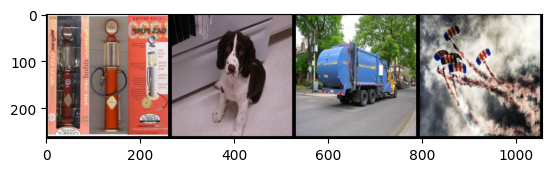

Class labels:  horse car   frog  truck


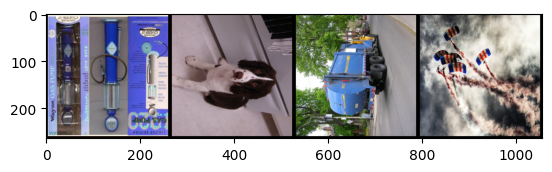

Rotation labels:  180   90    270   0    


In [7]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

In [8]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            #
            #
            #
            # Calculate outputs by running images through the network


            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)

            #correct += labels.size(0)
            total += labels.size(0)
            # loss
            correct += (predicted == labels).sum().item()
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
            
            # doubt on below line
            #total += avg_test_loss


    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {(100 * correct) / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [9]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [10]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'


device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cpu'

In [11]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [11]:
net = models.resnet50(pretrained=True)
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 92.6MB/s]


In [12]:
device

'cpu'

In [13]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

In [14]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()
        adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

        
        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            #

            # TODO: Zero the parameter gradients
            #

            # TODO: forward + backward + optimize
            #
            #
            #
            #
            #
            # Set the data to the correct device; Different task will use different inputs and labels
            if task == 'rotation':
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
              images, labels = imgs.to(device), cls_label.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # TODO: Get predicted results

            predicted = torch.argmax(outputs, 1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        #
        #
        net.eval()
        run_test(net, testloader, criterion, task)

    print('Finished Training')

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
train(net, criterion, optimizer, num_epochs=4, decay_epochs=5, init_lr=0.01, task='classification')


We have trained both

In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.models as models
from PIL import Image

# 1. Download the ImageNette dataset
# Go to https://github.com/fastai/imagenette and follow the instructions to download the dataset

# 2. Create a custom dataset loader
class ImageNetteRotDataset(Dataset):
    def __init__(self, root, transform=None):
        self.data = ImageFolder(root)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img, _ = self.data[index]
        rot_label = np.random.choice([0, 1, 2, 3])
        img = img.rotate(90 * rot_label)

        if self.transform:
            img = self.transform(img)

        return img, rot_label

# 3. Prepare data transformations
data_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Set the dataset path
imagenette_train_path = '/content/drive/MyDrive/assignment3_starter/assignment3_part1/imagenette2-160/train'

# 4. Instantiate the model
resnet50 = models.resnet50(pretrained=True)
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, 4)

# 5. Train the model on the rotation prediction task
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet50 = resnet50.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10
train_dataset = ImageNetteRotDataset(imagenette_train_path, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / (i + 1)
    epoch_acc = correct / total * 100
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

print('Finished training the rotation prediction model.')


Epoch 1/10, Loss: 0.8177, Accuracy: 62.93%
Epoch 2/10, Loss: 0.3756, Accuracy: 85.67%
Epoch 3/10, Loss: 0.2964, Accuracy: 89.21%
Epoch 4/10, Loss: 0.2598, Accuracy: 90.52%
Epoch 5/10, Loss: 0.2168, Accuracy: 91.95%
Epoch 6/10, Loss: 0.1750, Accuracy: 93.64%
Epoch 7/10, Loss: 0.1587, Accuracy: 94.43%
Epoch 8/10, Loss: 0.1389, Accuracy: 95.28%
Epoch 9/10, Loss: 0.1303, Accuracy: 95.63%
Epoch 10/10, Loss: 0.1152, Accuracy: 95.91%
Finished training the rotation prediction model.
